<a href="https://colab.research.google.com/github/oferweintraub/finance_sent/blob/main/Finance_sentimet_anaysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Finance sentiment analysis basd on Kaggle data - https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news 


In [44]:
# let's first import few libraries
import pandas as pd
import numpy as np
import plotly.express as px



In [45]:
# get the data
header_list = ["sentiment", "text"]
df_orig = pd.read_csv('/content/drive/MyDrive/data/Kaggle financial sentiment/all-data.csv', engine='python', names=header_list)

df = df_orig.copy(deep=True)

In [46]:
# explre the data
df.head() # 2 colums with sentiment and text

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [47]:
df.shape # 4846 examples

(4846, 2)

In [48]:
# let's look at the types
df.info() # all non-null and object type i.e. string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   text       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [49]:
# convert sentiments to integers
# negative - 0
# neutral - 1
# positive - 2

def sentiment_to_int(sentiment):
  if (sentiment.strip()  == 'negative'):
    return int(0)
  elif (sentiment.strip()  == 'neutral'):
    return int(1)
  elif (sentiment.strip()  == 'positive'):
    return int(2)
  else:
      return int(10)

df['sentiment'] = df['sentiment'].apply(sentiment_to_int)

In [50]:
# now our df looks like
df.head()

,sentiment,text
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [51]:
# in the first iteration let's remain with negative and positive only i.e. 0 and 2
df = df[(df['sentiment'] == 0) | (df['sentiment'] == 2)]

In [52]:
df.shape # down to 1967 examples only

(1967, 2)

In [53]:
# what's the distribution between positive and negative?

fig = px.histogram(df, x='sentiment', color='sentiment', width=800, color_discrete_sequence=['red','magenta'])
   

fig.update_layout(
    title_text='financial sentiment -  0 - negative, 2 - positive', # title of plot
    #xaxis_title_text=' labels', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.5, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    showlegend=False
)
fig.show() # so very similar distribution

# we see the data is quite unbalanced, twice as more positive reviews than negative --> we will test stratifying later

In [54]:
# install clean text
!pip install cleantext

In [55]:
# get the cleantext module
from cleantext import clean

import nltk
nltk.download('stopwords')

# define a function to do the cleaning
def clean_it(sentence):
  return clean(sentence,  
      stemming=True,
      stopwords=True,
      lowercase=True,
      numbers=True,
      punct=True,
      stp_lang='english')
  # or just use --> clean(sentence, all=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
# let's clen the text
df['text'] = df['text'].apply(clean_it)

In [57]:
# now te df look like
df.head()

,sentiment,text
2,0,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year baswar ta...
5,2,financ aspocomp growth aspocomp aggress pursu ...
6,2,last quarter componenta net sale doubl eurm ...


In [58]:
# below we test 2 tokenizers to see if there is any difference, spoiler alert...no difference

# start with the standars treebanktkenizer
import nltk
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer ()

def tokenize_it(sentence):
  return tokenizer.tokenize(sentence)


# Let's also prepare another tokenizer here to test -porterstemmer
from nltk.stem.porter import PorterStemmer
stemming = PorterStemmer( )

def tokenizer_stemmer(text):
  return [stemming.stem(word) for word in text.split()]


In [59]:
# now create tfidf representation of the text
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer( lowercase=False,
                        tokenizer=tokenizer_stemmer,
                        ngram_range=(1,2),
                        use_idf=True,
                        smooth_idf=True,
                        )
X = tfidf.fit_transform(df['text'])
y = df['sentiment'].values

In [60]:
# let's see if normalization helps?---> well... NO
# from sklearn.preprocessing import StandardScaler
                                             
# scaler = StandardScaler() 
# X1 = scaler.fit_transform(X.toarray())

# actually, normalization made it worst... 

In [61]:
# check dimensions
X.shape, y.shape

((1967, 18990), (1967,))

In [62]:
# split the data for training and evaluations
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [63]:
# now apply logistic refgression to the data
import pickle
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV( cv=5,
                              n_jobs=-1,
                              random_state=42, 
                              verbose =3,
                              max_iter=400)
clf.fit(x_train, y_train) # since we automatically perform cross validation on the training we can use the entire training set

# save the results 
saved_model = open('/content/drive/MyDrive/data/Kaggle financial sentiment/logistic_regression.sav', 'wb')
pickle.dump(clf, saved_model)
saved_model.close()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.9s finished


In [64]:
# let's look at the results but first upload te data

filename = '/content/drive/MyDrive/data/Kaggle financial sentiment/logistic_regression.sav'
clf = pickle.load(open(filename, 'rb'))

In [65]:
# now the accuracy
clf.score(x_test, y_test)

0.8401015228426396

In [66]:
from sklearn import metrics

y_pred = clf.predict(x_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.60      0.89      0.71        88
           2       0.96      0.83      0.89       306

    accuracy                           0.84       394
   macro avg       0.78      0.86      0.80       394
weighted avg       0.88      0.84      0.85       394



In [67]:
# let's look at the confussion matrix
cf_matrix= metrics.confusion_matrix(y_pred, y_test)
print(cf_matrix)

[[ 78  10]
 [ 53 253]]


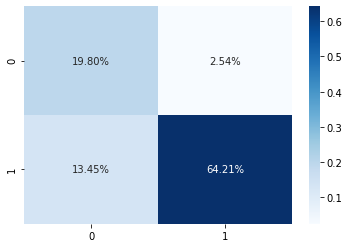

In [68]:
# 'we can also do the above with seaborn
import seaborn as sns


sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')